In [529]:
# =========================
# IMPORT LIBARY ===========
# =========================

import pandas as pd # Import library untuk manipulating dataset
import seaborn as sns # Import library untuk visualisasi EDA
import numpy as np # Import library untuk manipulating number data

from pandas.api.types import is_string_dtype, is_numeric_dtype # Import library untuk membaca type data column Dataframe
from matplotlib import pyplot as plt # Import library untuk Exploratory Data Analysis
from tkinter import * # Import library untuk pembuatan GUI
from tkinter import ttk # Import library turunan TKInter untuk tambahan widget dan component

data_path = 'datasets/diabetes_data_upload.csv' # membuat variable untuk menyimpan path data ke dataset

df = pd.read_csv(data_path) #membaca dataset dari variable data_path 

df.head() # menampilkan 5 data teratas

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive


In [530]:
df.shape # cek dimensi data sebelum masuk pre-processing

(520, 17)

In [531]:
df.nunique() # mengecek data unik pada setiap kolom

Age                   51
Gender                 2
Polyuria               2
Polydipsia             2
sudden weight loss     2
weakness               2
Polyphagia             2
Genital thrush         2
visual blurring        2
Itching                2
Irritability           2
delayed healing        2
partial paresis        2
muscle stiffness       2
Alopecia               2
Obesity                2
class                  2
dtype: int64

In [532]:
df.info() # menampilkan informasi dari data frame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Age                 520 non-null    int64 
 1   Gender              520 non-null    object
 2   Polyuria            520 non-null    object
 3   Polydipsia          520 non-null    object
 4   sudden weight loss  520 non-null    object
 5   weakness            520 non-null    object
 6   Polyphagia          520 non-null    object
 7   Genital thrush      520 non-null    object
 8   visual blurring     520 non-null    object
 9   Itching             520 non-null    object
 10  Irritability        520 non-null    object
 11  delayed healing     520 non-null    object
 12  partial paresis     520 non-null    object
 13  muscle stiffness    520 non-null    object
 14  Alopecia            520 non-null    object
 15  Obesity             520 non-null    object
 16  class               520 no

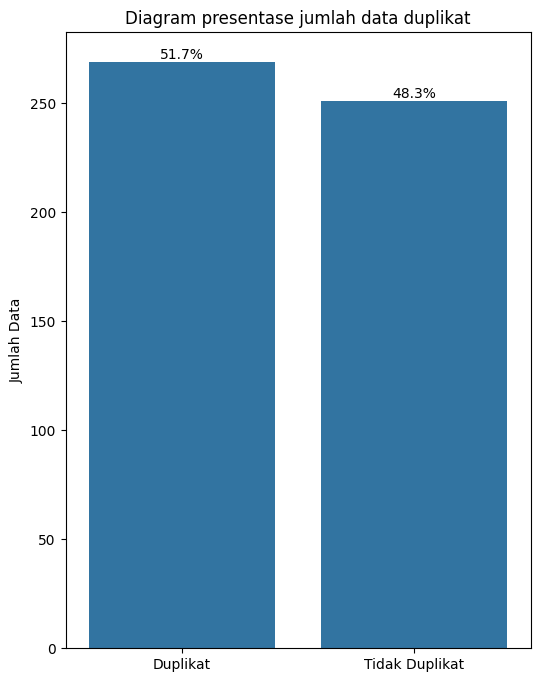

In [533]:
# barplot melihat jumlah data duplicate
plt.figure(figsize=(6, 8))
plt.title("Diagram presentase jumlah data duplikat")

count_duplicate = df.duplicated().sum()
non_duplicate = len(df) - count_duplicate
total = count_duplicate + non_duplicate

precentages = [
    count_duplicate / total * 100,
    non_duplicate / total * 100
    
]

res = sns.barplot(
    x=['Duplikat', 'Tidak Duplikat'],
    y=[count_duplicate, non_duplicate]
)

for i, p in enumerate(res.patches):
    res.text(
        p.get_x() + p.get_width() / 2,
        p.get_height(),
        f'{precentages[i]:.1f}%',
        ha='center',
        va='bottom'
    )

plt.ylabel("Jumlah Data")
plt.show()


In [534]:
# =====================
# DATA PREPROCESSING ==
# =====================

df.isna().sum() # mengecek data yang kosong
df.duplicated().sum() # mengecek data yang duplikat

np.int64(269)

In [535]:
df = df.drop_duplicates() # menghapus data duplikat dan melakukan reset index
df = df.fillna(df.mode().iloc[0])

In [536]:
df.shape #mengecek dimensi data setelah menghapus data duplikat

(251, 17)

In [537]:
df.nunique()

Age                   51
Gender                 2
Polyuria               2
Polydipsia             2
sudden weight loss     2
weakness               2
Polyphagia             2
Genital thrush         2
visual blurring        2
Itching                2
Irritability           2
delayed healing        2
partial paresis        2
muscle stiffness       2
Alopecia               2
Obesity                2
class                  2
dtype: int64

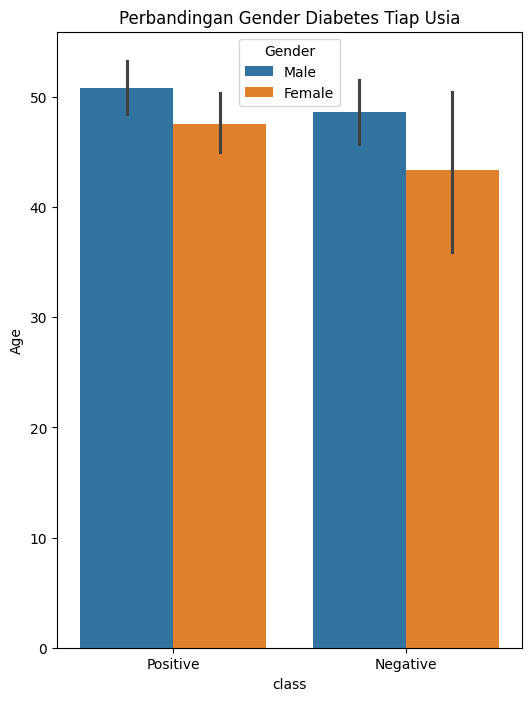

In [538]:
plt.figure(figsize=(6,8))
sns.barplot(data=df, y="Age", x="class", hue="Gender")
plt.title("Perbandingan Gender Diabetes Tiap Usia")
plt.show()


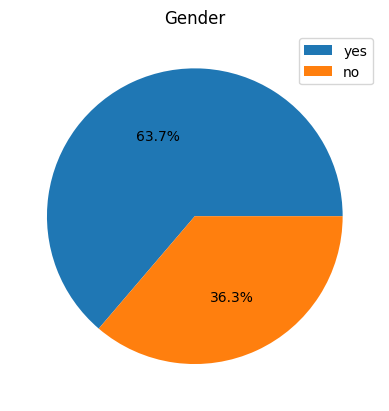

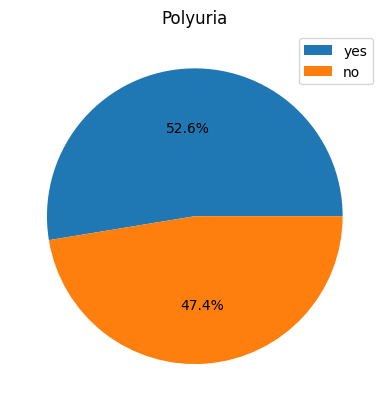

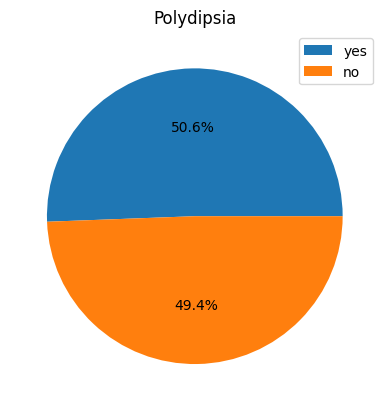

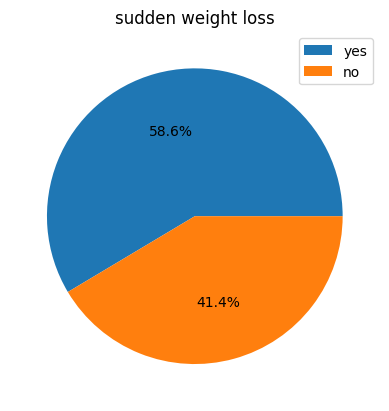

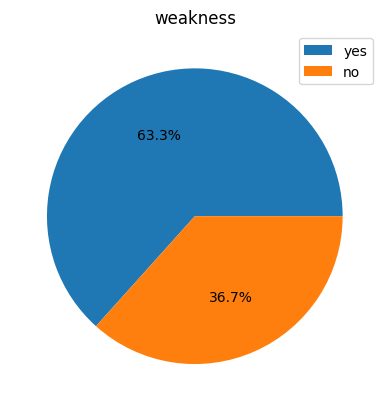

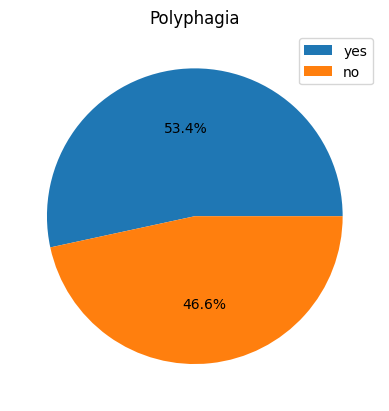

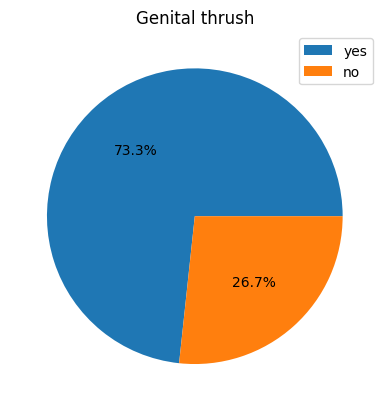

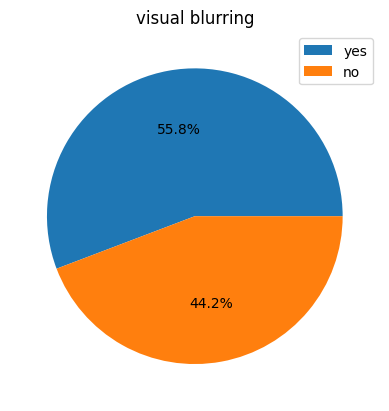

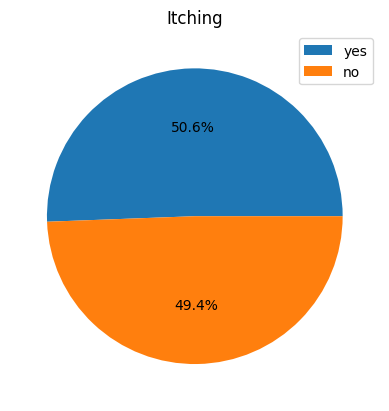

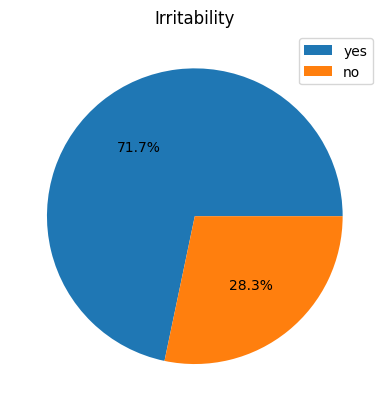

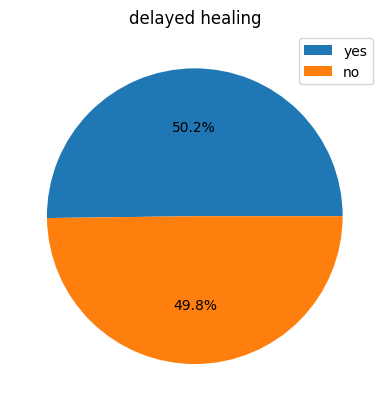

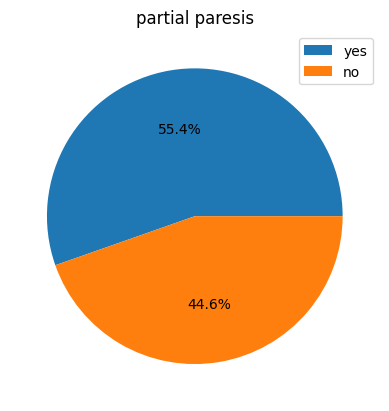

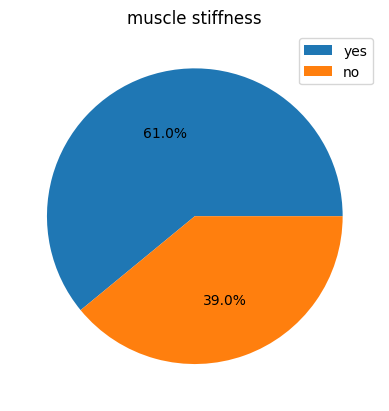

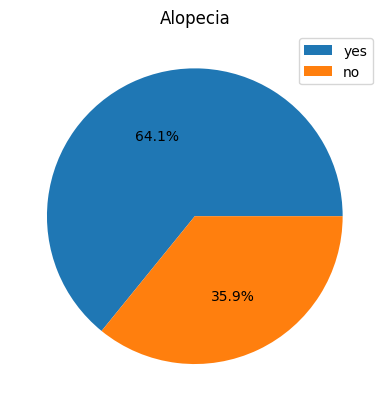

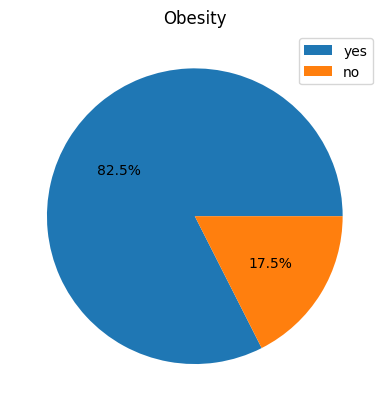

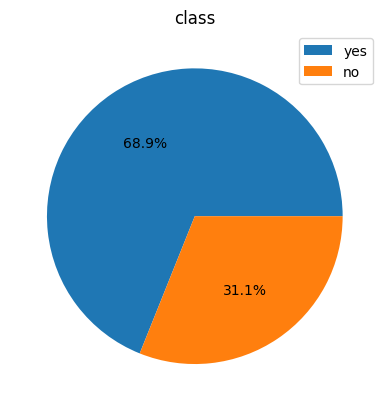

In [539]:
for x in df.select_dtypes(exclude=['int64']):
    plt.pie(df[x].value_counts(), autopct='%1.1f%%')
    legend = [
        'yes',
        'no'
    ]
    if x == 'gender':
        legend = [
            'male',
            'female'
        ]
    plt.legend(legend) 
    plt.title(x)
    plt.show()

In [540]:
def encode_column(col): # membuat function untuk melakukan encoding data dengan variable unique
    unique_vals = col.unique()
    mapping = {val: idx for idx, val in enumerate(unique_vals)}
    return col.map(mapping)


for col in df.columns: # melakukan encoding data pada column variable df
    if df[col].dtype == "object":
        df[col] = encode_column(df[col])

df.columns = df.columns.str.lower().str.replace(' ', '_')

In [541]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None 

In [542]:
class DecisionTree:
    def __init__(self, n_features, min_best_split = 2, max_depth = 2):
        self.min_best_split = min_best_split
        self.max_depth = max_depth
        self.n_features = n_features
        self.root=None
    
    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1],self.n_features)
        self.root = self._growing_tree(X, y, depth=0)

    def _growing_tree(self, X, y, depth=0):
        n_sample, n_feats = X.shape
        n_labels = len(np.unique(y))

        if (depth >= self.max_depth or n_labels == 1 or n_sample < self.min_best_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)

        best_feature, best_thresh = self.find_best_split(X, y, feat_idxs)
        left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)

        left = self._growing_tree(X[left_idxs], y[left_idxs], depth+1)
        right = self._growing_tree(X[right_idxs], y[right_idxs], depth+1)

        return Node(best_feature, best_thresh, left, right)
        
    def _most_common_label(self, y):
        from collections import Counter
        counter = Counter(y)
        value = counter.most_common(1)[0][0]
        return value

    def find_best_split(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_threshold = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)
                
                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = threshold

        return split_idx, split_threshold

    def _information_gain(self, y, X_column, threshold):
        parent_entropy = self._entropy(y)

        left_idx, right_idx = self._split(X_column, threshold)
        if len(left_idx) == 0 or len(right_idx) == 0:
            return 0

        n = len(y)
        n_l, n_r = len(left_idx), len(right_idx)
        e_l, e_r = self._entropy(y[left_idx]), self._entropy(y[right_idx])

        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r

        information_gain = parent_entropy - child_entropy
        return information_gain

    def _split(self, X_column, split_threshold):
        left_idxs = np.argwhere(X_column <= split_threshold).flatten()
        right_idxs = np.argwhere(X_column > split_threshold).flatten()
        return left_idxs, right_idxs

    def _entropy(self, y):
        if y.dtype == 'object' or not np.issubdtype(y.dtype, np.integer):
            y = y.astype(int)
        hist = np.bincount(y)
        p = hist / len(y)

        return -np.sum([x * np.log(x) for x in p if x > 0])

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        else:
            return self._traverse_tree(x, node.right)
    

In [543]:
X = df.drop('class', axis=1).values
y = df['class'].values

y = y.astype(int)

X = X.astype(float)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

classify = DecisionTree(n_features=None, min_best_split=5, max_depth=10)
classify.fit(X_train, y_train)

predictions = classify.predict(X_test)

def accuracy(y_test, predictions):
    return np.sum(y_test == predictions) / len(y_test)

acc = accuracy(y_test, predictions)
print(f"Accuracy: {acc:.4f} ({acc*100:.2f}%)")

ModuleNotFoundError: No module named 'sklearn'